# Survival Analysis of Renal Cancer Alternative Outcomes: Tumor Recurrence

## Step 1: Import Data and Dependencies

In [1]:
import pandas as pd
import cptac
import deva
import gseapy as gp
from gseapy.plot import barplot, heatmap, dotplot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import lifelines
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
%matplotlib inline

In [2]:
renal = cptac.Ccrcc()
follow_up = renal.get_followup()
proteomics = renal.get_proteomics()

## Step 2: Data Preparation
We will be focusing on the discovery cohort of tumors, for which we have follow-up data. We will first merge the clinical and follow-up tables together for analysis. Then we will choose a few attributes to focus on, and narrow our dataframe to those attributes. While you could study a wide variety of factors related to survival, such as country of origin or number of full pregnancies, we will be focusing on tumor stage and grade.

In [3]:
follow_up.columns

Index(['Cohort', 'Tumor code', 'Follow-up Period', 'Lost to Follow-up?',
       'Vital Status', 'Path Diag to Last Contact(Day)', 'Cause of Death',
       'Path Diag to Death(days)', 'Adj Post-Op Radiation Therapy',
       'Adj Post-Op Pharma Therapy', 'Adj Post-Op Immuno Therapy',
       'Tumor Status', 'Success of Initial Treatment',
       'Success of Treament @ Followup', 'ECOG Score', 'Karnofsky Score',
       'Perform Status Scale: Timing', 'Other Perform Scale Timing',
       'New Tumor After Initial TRT', 'Path Diag to new Tumor days',
       'Additional Surgery ?', 'Path Diag to Surgery days     ',
       'Additional Surgery for Mets ?', 'Path Diag to Mets Surgery days',
       'Radiation for New Tumor', 'Pharmaceutical for New Tumor',
       'Immunological for New Tumor'],
      dtype='object', name='Name')

## Step 2b: Prepare data for Kaplan Meier Plotting
We will start by finding all patients that have died during the follow-up period and update the column to contain boolean values, where True denotes that the event occurred ('New Tumor Event'), and False denotes that it did not ('No New Tumor Event').  This is necessary to fit the requirements of the *lifelines* package.

In [4]:
annotations = deva.binarize_annotations(follow_up[['Success of Initial Treatment']])

In [5]:
annotations['Success of Initial Treatment_Persistent Disease'].value_counts()

not-Persistent Disease    191
Persistent Disease         38
Name: Success of Initial Treatment_Persistent Disease, dtype: int64

In [6]:
outliers, qvalues = deva.run_outliers(proteomics.transpose(),
                                      annotations,
                                      up_or_down='up',
                                      aggregate=False,
                                      frac_filter=0.3)

04/23/2020 12:02:58:WARNING:These samples were not found in outliers table: C3L-00789, C3L-00789, C3L-00815, C3L-00815, C3L-00966, C3L-00966, C3L-00980, C3L-00980, C3L-00981, C3L-00981, C3L-00982, C3L-00982, C3L-00991, C3L-01033, C3L-01034, C3L-01107, C3L-01459, C3L-01462, C3L-01462, C3L-01464, C3L-01464, C3L-01470, C3L-01929, C3L-01951, C3L-01952, C3L-01958, C3L-01958, C3L-01963, C3L-02175, C3L-02176, C3L-02177, C3L-02201, C3L-02201, C3L-02202, C3L-02202, C3L-02208, C3L-02208, C3L-02211, C3L-02214, C3L-02841, C3L-02841, C3L-02842, C3L-02842, C3L-02856, C3L-02857, C3N-01654, C3N-01654, C3N-01655, C3N-01806, C3N-01905, C3N-01905, C3N-01989, C3N-02005, C3N-02015, C3N-02015, C3N-02063, C3N-02066, C3N-02068, C3N-02070, C3N-02082, C3N-02084, C3N-02085, C3N-02262, C3N-02262, C3N-02263, C3N-02263, C3N-02264, C3N-02265, C3N-02265, C3N-02266, C3N-02332, C3N-02338, C3N-02431, C3N-02439, C3N-02439, C3N-02577, C3N-02763, C3N-02811, C3N-03018, C3N-03019, C3N-03021, C3L-00165, C3L-00968, C3L-00968, 

In [7]:
outliers.df.index = outliers.df.index.droplevel('Database_ID')
outliers_df = outliers.df

In [8]:
outliers_df = outliers_df.loc[:,~outliers_df.columns.str.endswith('notOutliers')]

In [9]:
gene_outlier_dict = {} #k: patient v: gene(s)
for i, gene in enumerate(outliers_df.index):
    outlier_filter = outliers_df.iloc[i] == 1.0
    value = list(outliers_df.iloc[i][outlier_filter].index)
    if len(value) > 0:
        gene_outlier_dict[gene] = value        

In [10]:
patient_outlier_dict = {} #k: gene v: patientID
transposed_df = outliers_df.transpose()
for i, patient in enumerate(transposed_df.index):
    patient = patient[:-9]
    outlier_filter = transposed_df.iloc[i] == 1.0
    value = list(transposed_df.iloc[i][outlier_filter].index)
    if len(value) > 0:
        patient_outlier_dict[patient] = value

In [11]:
cols_of_interest = ['Path Diag to Last Contact(Day)', 'Tumor Status',
                    'New Tumor After Initial TRT', 'Path Diag to new Tumor days',
                    'Radiation for New Tumor', 'Pharmaceutical for New Tumor', 
                    'Immunological for New Tumor', 'Success of Initial Treatment',
                    'Success of Treament @ Followup']

In [12]:
focus_group = follow_up[cols_of_interest].copy()

In [13]:
'''
#Experimental code with genes found by GSEA and outliers
genes_list = ['HLA-DRB3', 'C1QC', 
              'MAPK11', 'CXCL8', 
              'C8G', 'MAPK9', 
              'C8A', 'MBL2', 
              'C4A', 'HLA-DRB4', 
              'C1QB', 'HSPA5', 
              'C1QA', 'C1R', 
              'C3', 'C9', 
              'C8B', 'SEC61B', 
              'C5', 'EIF2AK3', 
              'C6', 'CALR', 'C2']

clinical_and_protein = renal.join_metadata_to_omics(metadata_df_name="followup", 
                                                 omics_df_name="proteomics", 
                                                 metadata_cols=cols_of_interest, 
                                                 omics_genes=genes_list)

clinical_and_protein = renal.reduce_multiindex(clinical_and_protein, 
                                            levels_to_drop="Database_ID")
'''

'\n#Experimental code with genes found by GSEA and outliers\ngenes_list = [\'HLA-DRB3\', \'C1QC\', \n              \'MAPK11\', \'CXCL8\', \n              \'C8G\', \'MAPK9\', \n              \'C8A\', \'MBL2\', \n              \'C4A\', \'HLA-DRB4\', \n              \'C1QB\', \'HSPA5\', \n              \'C1QA\', \'C1R\', \n              \'C3\', \'C9\', \n              \'C8B\', \'SEC61B\', \n              \'C5\', \'EIF2AK3\', \n              \'C6\', \'CALR\', \'C2\']\n\nclinical_and_protein = renal.join_metadata_to_omics(metadata_df_name="followup", \n                                                 omics_df_name="proteomics", \n                                                 metadata_cols=cols_of_interest, \n                                                 omics_genes=genes_list)\n\nclinical_and_protein = renal.reduce_multiindex(clinical_and_protein, \n                                            levels_to_drop="Database_ID")\n'

In [14]:
#Make the Vital Status column boolean
focus_group['New Tumor After Initial TRT'] = focus_group['New Tumor After Initial TRT'].replace('No', False)
focus_group['New Tumor After Initial TRT'] = focus_group['New Tumor After Initial TRT'].replace('Yes', True)
focus_group['New Tumor After Initial TRT'] = focus_group['New Tumor After Initial TRT'].astype(bool)

In [15]:
initial_tumor_group = focus_group[focus_group['Tumor Status'] == 'With Tumor']

In [16]:
persistent_disease = initial_tumor_group[initial_tumor_group['Success of Initial Treatment'] == 'Persistent Disease']

In [17]:
common_outliers_persistent_disease = []
for patient in persistent_disease.index:
    if patient in patient_outlier_dict.keys():
        common_outliers_persistent_disease += patient_outlier_dict[patient]

In [18]:
common_outliers_set = set(common_outliers_persistent_disease)

In [19]:
len(common_outliers_set)

1423

In [20]:
gene_name_list = list(common_outliers_set)

In [21]:
#print('Gene List:', gene_name_list, '\n')
name = "GSEA_Test"
enrichment = gp.enrichr(gene_list = gene_name_list, 
                        description=name, 
                        gene_sets='KEGG_2019_Human', 
                        outdir='test/renal')

In [22]:
persistent_disease_gsea = enrichment.res2d
sig_filter = persistent_disease_gsea['Adjusted P-value'] < 0.05
persistent_disease_sig = persistent_disease_gsea[sig_filter]
persistent_disease_sig[['Term', 'Overlap', 'Adjusted P-value']]

,Term,Overlap,Adjusted P-value
0,Complement and coagulation cascades,39/79,1.059439e-21
1,Protein processing in endoplasmic reticulum,36/165,1.718690e-07
2,Prion diseases,13/35,3.905552e-05
3,Staphylococcus aureus infection,18/68,6.263077e-05
4,Autophagy,26/128,5.939105e-05
5,N-Glycan biosynthesis,14/50,3.377985e-04
6,Amino sugar and nucleotide sugar metabolism,12/48,4.448315e-03
7,Systemic lupus erythematosus,22/133,6.595882e-03
8,Pertussis,15/76,8.827672e-03
9,Phagosome,23/152,1.444647e-02


In [23]:
genes = persistent_disease_sig['Genes']
terms = persistent_disease_sig['Term']
gsea_results_dict = {}
for i, gene in enumerate(genes):
    gsea_results_dict[terms[i]] = gene.split(';')

In [24]:
gsea_genes_occurrences = {}
for gene in gene_name_list:
    gsea_genes_occurrences[gene] = 0

In [25]:
for k, v in gsea_results_dict.items():
    for gene in v:
        gsea_genes_occurrences[gene] += 1        

In [26]:
genes_to_test = []
for k, v in gsea_genes_occurrences.items():
    if v > 2:
        genes_to_test.append(k)

In [27]:
print(genes_to_test)

['HLA-DRB4', 'C2', 'C8B', 'C1QB', 'CXCL8', 'C1R', 'MAPK9', 'MBL2', 'C6', 'EIF2AK3', 'HLA-DRB3', 'C1QC', 'C1QA', 'C8G', 'HSPA5', 'C9', 'C8A', 'SEC61B', 'MAPK11', 'CALR', 'C3', 'C4A', 'C5']


In [28]:
focus_group.columns

Index(['Path Diag to Last Contact(Day)', 'Tumor Status',
       'New Tumor After Initial TRT', 'Path Diag to new Tumor days',
       'Radiation for New Tumor', 'Pharmaceutical for New Tumor',
       'Immunological for New Tumor', 'Success of Initial Treatment',
       'Success of Treament @ Followup'],
      dtype='object', name='Name')

In [29]:
cols = ['Path Diag to Last Contact(Day)', 'Path Diag to new Tumor days']

focus_group = focus_group.assign(Days_Until_Last_Contact_Or_New_Tumor_Event=focus_group[cols].sum(1)).drop(cols, 1)

In [30]:
cols_to_plot = ['New Tumor After Initial TRT', 
                'Days_Until_Last_Contact_Or_New_Tumor_Event', 
                'Radiation for New Tumor', 
                'Pharmaceutical for New Tumor']
df_clean = focus_group[cols_to_plot].dropna(axis=0, how='any')

In [31]:
''' Need to append the proteomics data to clinical first before I can do much of this
new_tumor = df_clean[df_clean["New Tumor After Initial TRT"] == True]
no_new_tumor = df_clean[df_clean["New Tumor After Initial TRT"] == False]
#living
for gene in genes_to_test:
    print(gene)
    print(scipy.stats.ttest_ind(new_tumor[gene], no_new_tumor[gene]), '\n')


df_genes = df_clean.copy()
for col in omics_genes:
    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)
    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)

    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])
    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])
    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])


proteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}
for gene in omics_genes:
    df_genes[gene] = df_genes[gene].map(proteomics_map)
    
focus_group = df_genes.copy()
'''

' Need to append the proteomics data to clinical first before I can do much of this\nnew_tumor = df_clean[df_clean["New Tumor After Initial TRT"] == True]\nno_new_tumor = df_clean[df_clean["New Tumor After Initial TRT"] == False]\n#living\nfor gene in genes_to_test:\n    print(gene)\n    print(scipy.stats.ttest_ind(new_tumor[gene], no_new_tumor[gene]), \'\n\')\n\n\ndf_genes = df_clean.copy()\nfor col in omics_genes:\n    lower_25_filter = df_genes[col] <= df_genes[col].quantile(.25)\n    upper_25_filter = df_genes[col] >= df_genes[col].quantile(.75)\n\n    df_genes[col] = np.where(lower_25_filter, "Lower_25%", df_genes[col])\n    df_genes[col] = np.where(upper_25_filter, "Upper_25%", df_genes[col])\n    df_genes[col] = np.where(~lower_25_filter & ~upper_25_filter, "Middle_50%", df_genes[col])\n\n\nproteomics_map = {"Lower_25%" : 1, "Middle_50%" : 2, "Upper_25%" : 3}\nfor gene in omics_genes:\n    df_genes[gene] = df_genes[gene].map(proteomics_map)\n    \nfocus_group = df_genes.copy()\n

# Step 3: Kaplan-Meier Plots
Kaplan Meier plots show us the probability of some event occuring over a given length of time, based on some attribute(s).  Oftentimes, they are used to plot the probability of death for clinical attributes, however they could also be used in a variety of other contexts.

Here, we show a general Kaplan Meier Plot of survival overall for our cohort, using the KaplanMeierFitter() from the lifelines package.

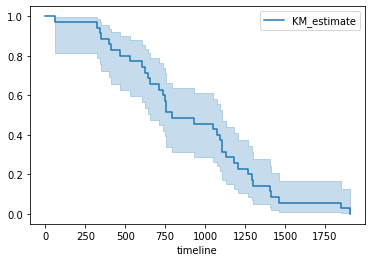

In [32]:
time = df_clean['Days_Until_Last_Contact_Or_New_Tumor_Event']
status = df_clean['New Tumor After Initial TRT']

kmf = KaplanMeierFitter()
kmf.fit(time, event_observed = status)
kmf.plot()

# Step 4: Format data for Cox's Proportional Hazard test

With the CoxPHFitter from the lifelines package we can see covariate survival plots, as shown below.  The variables we are interested in exploring are Tumor Stage, RAC2, and PODXL protein abundance.

First we will fit our model to the data we have prepared using the CoxPHFitter() class from the lifelines module.

In [33]:
bool_map = {"No" : 0, "Yes" : 1}
cols_to_clean = ['Radiation for New Tumor', 
                 'Pharmaceutical for New Tumor']
for col in cols_to_clean:
    df_clean[col] = df_clean[col].map(bool_map)

In [34]:
cph = CoxPHFitter()
cph.fit(df_clean, duration_col = "Days_Until_Last_Contact_Or_New_Tumor_Event", 
        event_col = "New Tumor After Initial TRT")

<lifelines.CoxPHFitter: fitted with 35 total observations, 0 right-censored observations>

Then we will plot each of the attributes to see how different levels of protein or different tumor stages affect survival outcomes in Ovarian Cancer patients.

In [35]:
#attributes = omics_genes.copy()
attributes = cols_to_clean.copy()

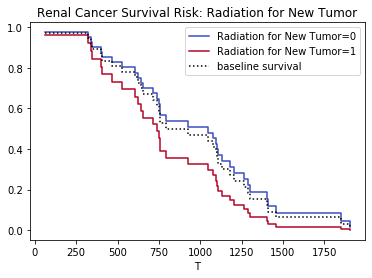

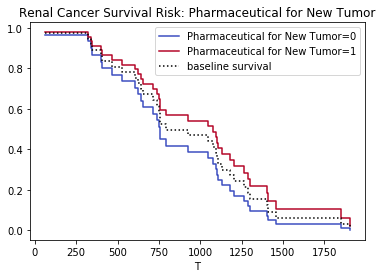

In [36]:
#attributes.append('Tumor_Stage_Ovary_FIGO')
#
for attribute in attributes:
    cph.plot_covariate_groups(attribute, [0,1], cmap='coolwarm', 
                          title= "Renal Cancer Survival Risk: " + attribute)

# Results
These different analyses tend to follow the baseline survival function, however, there are some differences in varying levels of each attribute. For example, FIGO Stage I tumors tend to have a higher survival rate over time comparatively to Stage III tumors.  We can explore these differences with the CoxPHFitter object's *print_summary* function (which prints out results for multivariate linear regression) and with the *proportional_hazard_test* (which performs Cox's Proportional Hazard Test on the data to determine how each attribute contributes to our cohort's overall survival).

In [37]:
cph.print_summary(model="untransformed variables", decimals=3)

<lifelines.CoxPHFitter: fitted with 35 total observations, 0 right-censored observations>
      duration col = 'Days_Until_Last_Contact_Or_New_Tumor_Event'
         event col = 'New Tumor After Initial TRT'
number of observations = 35.0
number of events observed = 35.0
partial log-likelihood = -91.288
  time fit was run = 2020-04-09 23:00:21 UTC
             model = untransformed variables


---
                               coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
Name                                                                                                                           
Radiation for New Tumor       0.504     1.655     0.455          -0.387           1.395               0.679               4.036
Pharmaceutical for New Tumor -0.430     0.650     0.403          -1.221           0.360               0.295               1.433

                                  z     p  -log2(p)
Name                                

In [38]:
results = proportional_hazard_test(cph, df_clean, time_transform='rank')
results.print_summary(decimals=3, model="untransformed variables")

<lifelines.StatisticalResult>
         test_name = proportional_hazard_test
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = untransformed variables

---
                              test_statistic     p  -log2(p)
Pharmaceutical for New Tumor           2.119 0.146     2.781
Radiation for New Tumor                0.143 0.705     0.504


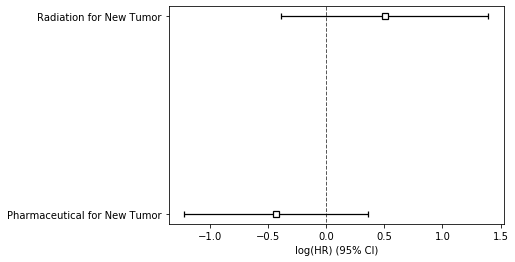

In [39]:
cph.plot()

In [40]:
cph.confidence_intervals_

,95% lower-bound,95% upper-bound
Name,,
Radiation for New Tumor,-0.387027,1.39518
Pharmaceutical for New Tumor,-1.220900,0.35992
